In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("../scripts")
import benchmark

In [3]:
abundance_threshold = 0.0001

In [4]:
subsp_def= pd.read_csv("../fullname_subsp_def_sourmash.txt",sep='\t',index_col=0,dtype={'subspecies':'category'})
subsp_def.subspecies = subsp_def.subspecies.str.rjust(10,"0")

In [5]:
output_df = pd.DataFrame()
to_remove = {}
for sample in range(0,10):
    sample_df = pd.read_csv(f"distributions/distribution_{sample}.txt",sep='\t',header=None,index_col=0,names=[f'reference_sample{sample}'])
    temp_df = subsp_def.merge(sample_df,left_index=True,right_index=True).set_index('subspecies',drop=True)
    temp_df = temp_df.T.groupby(level=0,axis=1).sum().T
    to_remove[sample]=temp_df.loc[temp_df.iloc[:,0] < 0.0001].index.to_list()
    output_df = pd.concat([output_df,temp_df],axis=1)
    
output_df = output_df.mask(output_df < abundance_threshold, 0)

In [6]:
test_df = pd.DataFrame()
for sample in range(0,10):
    gather_df = pd.read_csv(f"gather/sample{sample}.csv")
    gather_df['name'] = gather_df['name'].astype(str).str.rjust(10,'0')
    gather_df = gather_df.set_index("name")
    gather_df = gather_df.loc[gather_df['intersect_bp'] >=10000]
    gather_df = gather_df.loc[gather_df['f_match'] > 0.01]
    #temp_df = temp_df.loc[~temp_df.index.isin(to_remove[sample])]
    temp_df = pd.DataFrame(gather_df['f_unique_weighted']/gather_df['f_unique_weighted'].sum())
    temp_df.columns = [f'test_sample{sample}']
    test_df = pd.concat([test_df,temp_df],axis=1)
relab = test_df.fillna(0)

#relab.index = relab.index.map(subsp_def['subspecies'].to_dict())
relab = relab.groupby(level=0, axis=0).sum()

In [7]:
metaphlan_performance = pd.read_csv("metaphlan_dist.tsv",sep='\t',index_col=0)

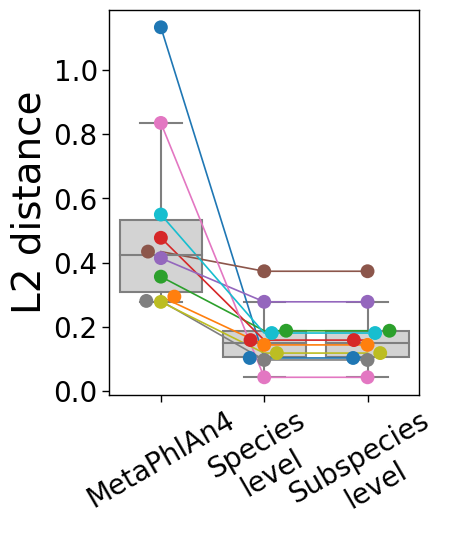

In [11]:
euc_distance_list_subsp = []
for sample in range(0,10):
    euc_distance = benchmark.l2_distance(relab[f'test_sample{sample}'],output_df[f'reference_sample{sample}'],subspecies=True)
    euc_distance_list_subsp.append(euc_distance)
    
euc_distance_list_sp = []
for sample in range(0,10):
    euc_distance = benchmark.l2_distance(relab[f'test_sample{sample}'],output_df[f'reference_sample{sample}'],subspecies=False)
    euc_distance_list_sp.append(euc_distance)
    
euc_distance_list_subsp.extend(euc_distance_list_sp)
euc_distance_list_subsp.extend(metaphlan_performance['L2_dist'].tolist())
l2_distance_df = pd.DataFrame()
l2_distance_df['L2_distance'] = euc_distance_list_subsp
l2_distance_df['level'] = ['Subspecies\nlevel']*10 + ['Species\nlevel']*10 + ['MetaPhlAn4']*10
l2_distance_df['sample'] = ['sample_0','sample_1','sample_2','sample_3','sample_4','sample_5','sample_6','sample_7','sample_8','sample_9']*3

l2_distance_df = l2_distance_df.sort_values(by='level')

sns.set_context('paper')
fig,ax = plt.subplots(figsize=(4,5))
sns.boxplot(data = l2_distance_df, x='level',y='L2_distance',ax=ax,color='lightgray', linewidth=1.5,)
sns.swarmplot(data = l2_distance_df, x='level',y='L2_distance',ax=ax,s=10,hue='sample')
sns.lineplot(x="level", y="L2_distance", hue='sample', data=l2_distance_df,estimator=None, legend=False)
#plt.title('L2 distance between reference and test abundances from HumGut MAGs.')
plt.xlabel("")
plt.ylabel("L2 distance",fontsize=28)
plt.xticks(fontsize=20, rotation=30)
plt.yticks(fontsize=20)
ax.get_legend().remove()
#plt.savefig("L2_distance_posthumgut.svg")

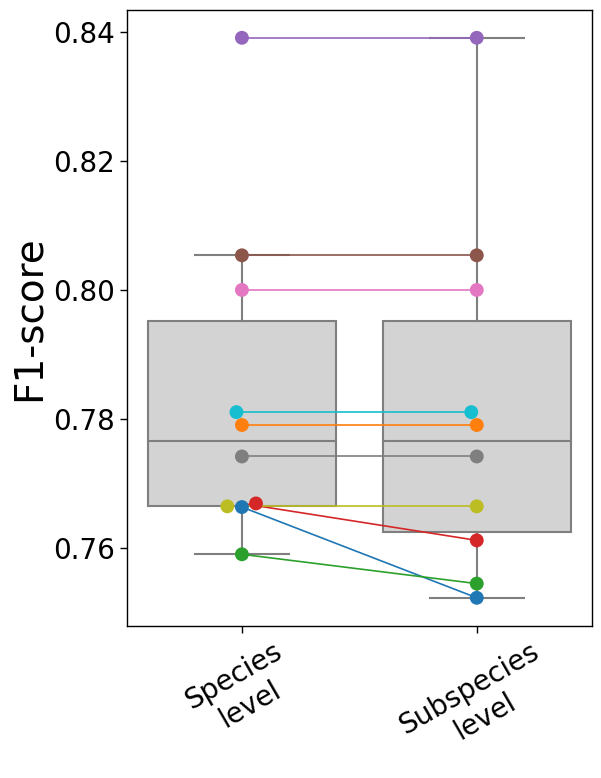

In [14]:
f1_list_subsp = []
for sample in range(0,10):
    _,_,f1 = benchmark.get_metrics(relab[f'test_sample{sample}'],output_df[f'reference_sample{sample}'],subspecies=True)
    f1_list_subsp.append(f1)
f1_list_sp = []
for sample in range(0,10):
    _,_,f1 = benchmark.get_metrics(relab[f'test_sample{sample}'],output_df[f'reference_sample{sample}'],subspecies=False)
    f1_list_sp.append(f1)

f1_list_subsp.extend(f1_list_sp)

f1 = pd.DataFrame()
f1['f1'] = f1_list_subsp
f1['level'] = ['Subspecies\nlevel']*10 + ['Species\nlevel']*10
f1['sample'] = ['sample_0','sample_1','sample_2','sample_3','sample_4','sample_5','sample_6','sample_7','sample_8','sample_9']*2

f1 = f1.sort_values(by='level')

sns.set_context('paper')
fig,ax = plt.subplots(figsize=(6,8))
sns.boxplot(data = f1, x='level',y='f1',ax=ax,color='lightgray', linewidth=1.5)
sns.swarmplot(data = f1, x='level',y='f1',ax=ax,s=10,hue='sample')
sns.lineplot(x="level", y="f1", hue='sample', data=f1,estimator=None, legend=False)
#plt.title('F1-score between reference and test abundances from HumGut MAGs.')
plt.xlabel("")
plt.ylabel("F1-score",fontsize=28)
plt.xticks(fontsize=20, rotation=30)
plt.yticks(fontsize=20)
#plt.ylim(0.75,1)
ax.get_legend().remove()
#plt.savefig("F1_score_posthumgut.svg")